<a href="https://colab.research.google.com/github/abh22/fraud_detect_steg/blob/main/Fraud_Detection_Starter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fraud Detection in Electricity and Gas Consumption Challenge

This is a simple starter notebook based on the tutorial prepared by Joy Wawira. Check out the article [here](https://zindi.africa/learn/fraud-detection-in-electricity-and-gas-consumption-challenge-tutorial) for a more detailed description of the steps taken.

This notebook covers:
- Downloading the data straight from Zindi and onto colab
- Loading the data and carrying out simple EDA to understand the data and prepare for modelling
- Preprocessing the data and feature engineering
- Creating a simple LGBM model and predicting on the test set
- Prepare submission file and save as csv
- Some tips on how to improve model performance and your score

# Pre-Requisites

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Prep

## Import Libraries

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm
from lightgbm import LGBMClassifier

import warnings
warnings.simplefilter('ignore')

## Read the Data

In [4]:
client_train = pd.read_csv(f'drive/MyDrive/data/client_train.csv', low_memory=False)
client_train.head()

,disrict,client_id,client_catg,region,creation_date,target
0,60,train_Client_0,11,101,31/12/1994,0.0
1,69,train_Client_1,11,107,29/05/2002,0.0
2,62,train_Client_10,11,301,13/03/1986,0.0
3,69,train_Client_100,11,105,11/07/1996,0.0
4,62,train_Client_1000,11,303,14/10/2014,0.0


In [5]:
invoice_train = pd.read_csv(f'drive/MyDrive/data/invoice_train.csv', low_memory=False)
invoice_train.head()

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,ELEC
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,ELEC
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,ELEC
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,ELEC
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,ELEC


In [6]:
client_test = pd.read_csv(f'drive/MyDrive/data/client_test.csv', low_memory=False)
client_test.head()

,disrict,client_id,client_catg,region,creation_date
0,62,test_Client_0,11,307,28/05/2002
1,69,test_Client_1,11,103,06/08/2009
2,62,test_Client_10,11,310,07/04/2004
3,60,test_Client_100,11,101,08/10/1992
4,62,test_Client_1000,11,301,21/07/1977


In [30]:
invoice_test = pd.read_csv(f'drive/MyDrive/data/invoice_test.csv', low_memory=False)


## Data Understanding

In [31]:
#compare size of the various datasets
print(client_train.shape, invoice_train.shape, client_test.shape, invoice_test.shape)

(150, 6) (400, 16) (58069, 5) (1939730, 16)


In [9]:
#Get a summary for all numerical columns
invoice_train.describe()

,tarif_type,counter_number,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number
count,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06
mean,2.012804e+01,1.230587e+11,1.724884e+02,7.321702e+00,1.003040e+00,4.109795e+02,1.093225e+02,2.030620e+01,5.292588e+01,1.776700e+04,1.834970e+04,4.483095e+01
std,1.347256e+01,1.657267e+12,1.338871e+02,1.571654e+00,3.083466e-01,7.573080e+02,1.220123e+03,1.574239e+02,8.754725e+02,4.036693e+04,4.095321e+04,3.128335e+03
min,8.000000e+00,0.000000e+00,0.000000e+00,5.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.100000e+01,1.211080e+05,5.000000e+00,6.000000e+00,1.000000e+00,7.900000e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.791000e+03,2.056000e+03,4.000000e+00
50%,1.100000e+01,4.945610e+05,2.030000e+02,8.000000e+00,1.000000e+00,2.740000e+02,0.000000e+00,0.000000e+00,0.000000e+00,7.690000e+03,8.192000e+03,4.000000e+00
75%,4.000000e+01,1.115161e+06,2.070000e+02,9.000000e+00,1.000000e+00,6.000000e+02,0.000000e+00,0.000000e+00,0.000000e+00,2.166000e+04,2.234300e+04,4.000000e+00
max,4.500000e+01,2.798115e+13,6.000000e+02,4.130000e+02,5.000000e+01,9.999100e+05,9.990730e+05,6.449200e+04,5.479460e+05,2.800280e+06,2.870972e+06,6.366240e+05


In [10]:
#Get a summary for all numerical columns
client_train.describe()

,disrict,client_catg,region,target
count,135493.000000,135493.000000,135493.000000,135493.000000
mean,63.511222,11.512506,206.159809,0.055841
std,3.354400,4.423761,104.207044,0.229614
min,60.000000,11.000000,101.000000,0.000000
25%,62.000000,11.000000,103.000000,0.000000
50%,62.000000,11.000000,107.000000,0.000000
75%,69.000000,11.000000,307.000000,0.000000
max,69.000000,51.000000,399.000000,1.000000


In [11]:
#Get concise information of each column in dataset
invoice_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4476749 entries, 0 to 4476748
Data columns (total 16 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   client_id             object
 1   invoice_date          object
 2   tarif_type            int64 
 3   counter_number        int64 
 4   counter_statue        object
 5   counter_code          int64 
 6   reading_remarque      int64 
 7   counter_coefficient   int64 
 8   consommation_level_1  int64 
 9   consommation_level_2  int64 
 10  consommation_level_3  int64 
 11  consommation_level_4  int64 
 12  old_index             int64 
 13  new_index             int64 
 14  months_number         int64 
 15  counter_type          object
dtypes: int64(12), object(4)
memory usage: 546.5+ MB


In [12]:
#Get concise information of each column in dataset
client_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135493 entries, 0 to 135492
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   disrict        135493 non-null  int64  
 1   client_id      135493 non-null  object 
 2   client_catg    135493 non-null  int64  
 3   region         135493 non-null  int64  
 4   creation_date  135493 non-null  object 
 5   target         135493 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 6.2+ MB


In [13]:
#Getting unique values on the invoice train data
for col in invoice_train.columns:
    print(f"{col} - {invoice_train[col].nunique()}")

client_id - 135493
invoice_date - 8275
tarif_type - 17
counter_number - 201893
counter_statue - 12
counter_code - 42
reading_remarque - 8
counter_coefficient - 16
consommation_level_1 - 8295
consommation_level_2 - 12576
consommation_level_3 - 2253
consommation_level_4 - 12075
old_index - 155648
new_index - 157980
months_number - 1370
counter_type - 2


In [14]:
#Getting unique values on the client train data
for col in client_train.columns:
    print(f"{col} - {client_train[col].nunique()}")

disrict - 4
client_id - 135493
client_catg - 3
region - 25
creation_date - 8088
target - 2


In [15]:
invoice_train=invoice_train.sample(400)
invoice_train

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
1350097,train_Client_14707,2012-03-12,11,217479,0,203,9,1,294,0,0,0,703,997,4,ELEC
780565,train_Client_121127,2006-08-06,10,8630418,0,202,6,1,200,207,0,0,39115,39522,4,ELEC
847723,train_Client_122980,2008-11-07,11,1083823,0,203,6,1,447,0,0,0,2333,2780,4,ELEC
2372782,train_Client_42701,1998-02-03,11,199388,0,203,6,1,0,0,0,0,0,0,4,ELEC
783313,train_Client_121198,2006-04-05,11,540946,0,203,6,1,438,0,0,0,10957,11395,4,ELEC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1727919,train_Client_25132,2015-09-15,40,6896246,0,5,8,1,307,0,0,0,3559,3866,8,GAZ
673551,train_Client_118153,2015-07-04,40,432829,0,5,9,1,62,0,0,0,761,823,4,GAZ
386957,train_Client_110428,2016-11-08,9,700880,0,202,9,1,1122,0,0,0,3722,4844,4,ELEC
4061823,train_Client_88655,2014-09-29,40,133650,0,5,8,1,132,0,0,0,4746,4878,8,GAZ


In [17]:
client_train=client_train.sample(150)
client_train

,disrict,client_id,client_catg,region,creation_date,target
65865,63,train_Client_37332,11,306,05/02/2019,0.0
41618,69,train_Client_1551,11,103,06/09/2011,0.0
953,69,train_Client_100854,11,107,27/01/2012,0.0
52931,63,train_Client_25692,11,101,24/12/1990,0.0
131428,60,train_Client_9634,11,101,20/08/2007,0.0
...,...,...,...,...,...,...
45509,63,train_Client_19011,11,311,23/08/2007,0.0
73185,62,train_Client_43920,11,305,24/08/2010,0.0
110460,69,train_Client_77469,11,107,22/10/1984,0.0
110127,63,train_Client_77169,11,313,12/02/2016,0.0


In [18]:
#check for missing values
invoice_train.isnull().sum()

client_id               0
invoice_date            0
tarif_type              0
counter_number          0
counter_statue          0
counter_code            0
reading_remarque        0
counter_coefficient     0
consommation_level_1    0
consommation_level_2    0
consommation_level_3    0
consommation_level_4    0
old_index               0
new_index               0
months_number           0
counter_type            0
dtype: int64

In [19]:
#check for missing values
client_train.isnull().sum()

disrict          0
client_id        0
client_catg      0
region           0
creation_date    0
target           0
dtype: int64

No missing values in train set

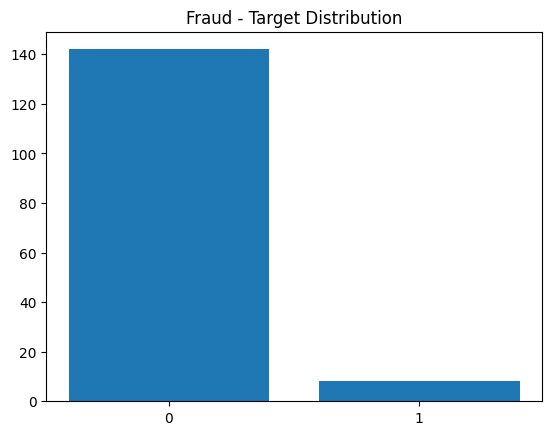

In [20]:
#Visualize fraudulent activities
fraudactivities = client_train.groupby(['target'])['client_id'].count()
plt.bar(x=fraudactivities.index, height=fraudactivities.values, tick_label = [0,1])
plt.title('Fraud - Target Distribution')
plt.show()

Target is highly imbalanced with fewer cases of fraudulent activities

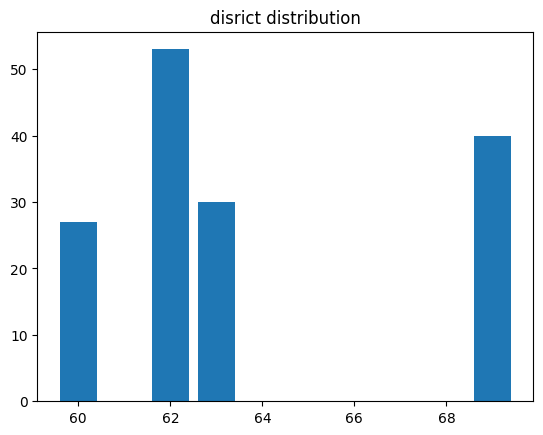

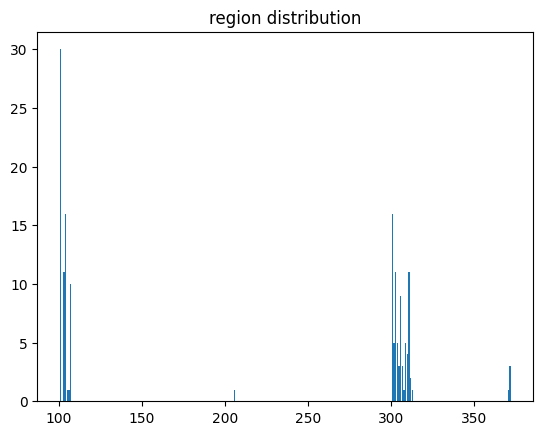

In [21]:
#Visualize client distribution across districts and regions
for col in ['disrict','region']:
    region = client_train.groupby([col])['client_id'].count()
    plt.bar(x=region.index, height=region.values)
    plt.title(col+' distribution')
    plt.show()

<Axes: xlabel='region', ylabel='count'>

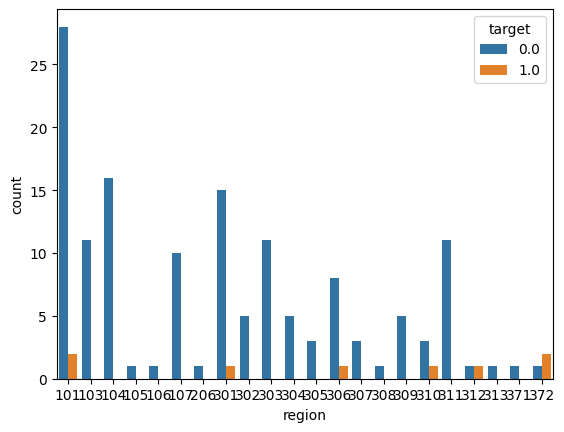

In [22]:
import seaborn as sns
sns.countplot(x='region',data=client_train,hue='target')

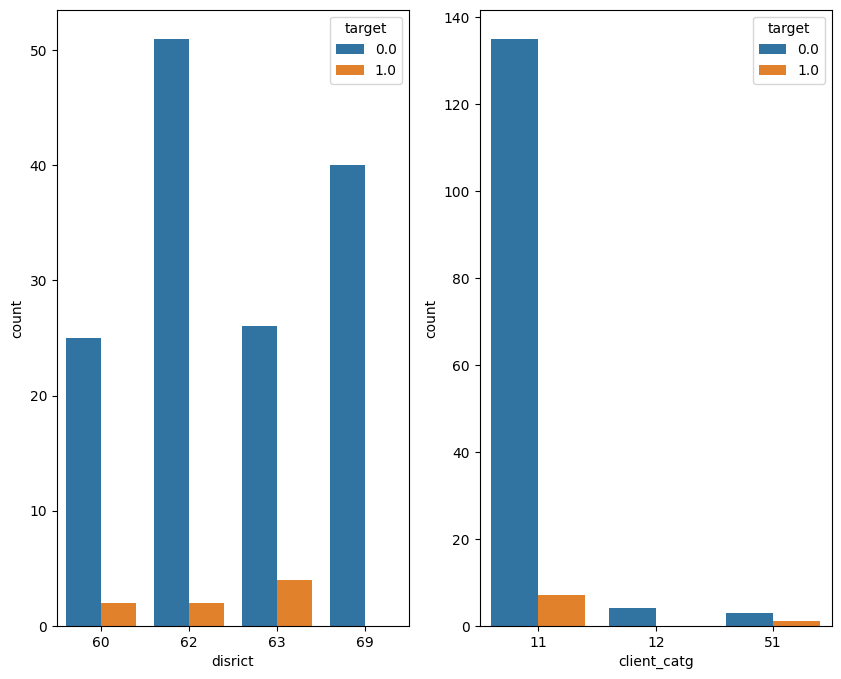

In [28]:
categ=['disrict','client_catg']
fig,axs=plt.subplots(nrows=1,ncols=2,figsize=(10,8))
axs=axs.flatten()
for i,elem in enumerate(categ):
  sns.countplot(x=elem,hue='target',data=client_train,ax=axs[i])
plt.show()

In [32]:
invoice_test=invoice_test.sample(80)
client_test=client_test.sample(30)

## Feature Engineering

In [33]:
#convert the column invoice_date to date time format on both the invoice train and invoice test
for df in [invoice_train,invoice_test]:
    df['invoice_date'] = pd.to_datetime(df['invoice_date'])

In [34]:
#encode labels in categorical column
d={"ELEC":0,"GAZ":1}
invoice_train['counter_type']=invoice_train['counter_type'].map(d)
invoice_test['counter_type']=invoice_test['counter_type'].map(d)

In [37]:
def aggregate_by_client_id(invoice_data):
    aggs = {}
    aggs['consommation_level_1'] = ['mean']
    aggs['consommation_level_2'] = ['mean']
    aggs['consommation_level_3'] = ['mean']
    aggs['consommation_level_4'] = ['mean']

    agg_trans = invoice_data.groupby(['client_id']).agg(aggs)
    agg_trans.columns = ['_'.join(col).strip() for col in agg_trans.columns.values]
    agg_trans.reset_index(inplace=True)

    df = (invoice_data.groupby('client_id')
            .size()
            .reset_index(name='{}transactions_count'.format('1')))
    return pd.merge(df, agg_trans, on='client_id', how='left')

In [38]:
#group invoice data by client_id
agg_train = aggregate_by_client_id(invoice_train)


In [39]:
agg_train

,client_id,1transactions_count,consommation_level_1_mean,consommation_level_2_mean,consommation_level_3_mean,consommation_level_4_mean
0,train_Client_100263,1,348.0,0.0,0.0,0.0
1,train_Client_100407,1,185.0,0.0,0.0,0.0
2,train_Client_100595,1,237.0,0.0,0.0,0.0
3,train_Client_100888,1,310.0,0.0,0.0,0.0
4,train_Client_100983,1,109.0,0.0,0.0,0.0
...,...,...,...,...,...,...
392,train_Client_96736,1,418.0,0.0,0.0,0.0
393,train_Client_96983,1,0.0,0.0,0.0,0.0
394,train_Client_98288,1,346.0,0.0,0.0,0.0
395,train_Client_99175,1,800.0,121.0,0.0,0.0


In [40]:
invoice_train['client_id'].nunique()

397

In [41]:

agg_train.head()

,client_id,1transactions_count,consommation_level_1_mean,consommation_level_2_mean,consommation_level_3_mean,consommation_level_4_mean
0,train_Client_100263,1,348.0,0.0,0.0,0.0
1,train_Client_100407,1,185.0,0.0,0.0,0.0
2,train_Client_100595,1,237.0,0.0,0.0,0.0
3,train_Client_100888,1,310.0,0.0,0.0,0.0
4,train_Client_100983,1,109.0,0.0,0.0,0.0


In [42]:
#merge aggregate data with client dataset
train = pd.merge(client_train,agg_train, on='client_id', how='left')

In [43]:
train

,disrict,client_id,client_catg,region,creation_date,target,1transactions_count,consommation_level_1_mean,consommation_level_2_mean,consommation_level_3_mean,consommation_level_4_mean
0,63,train_Client_37332,11,306,05/02/2019,0.0,NaN,NaN,NaN,NaN,NaN
1,69,train_Client_1551,11,103,06/09/2011,0.0,NaN,NaN,NaN,NaN,NaN
2,69,train_Client_100854,11,107,27/01/2012,0.0,NaN,NaN,NaN,NaN,NaN
3,63,train_Client_25692,11,101,24/12/1990,0.0,NaN,NaN,NaN,NaN,NaN
4,60,train_Client_9634,11,101,20/08/2007,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
145,63,train_Client_19011,11,311,23/08/2007,0.0,NaN,NaN,NaN,NaN,NaN
146,62,train_Client_43920,11,305,24/08/2010,0.0,NaN,NaN,NaN,NaN,NaN
147,69,train_Client_77469,11,107,22/10/1984,0.0,NaN,NaN,NaN,NaN,NaN
148,63,train_Client_77169,11,313,12/02/2016,0.0,NaN,NaN,NaN,NaN,NaN


In [44]:
train.fillna(0,inplace=True)
train

,disrict,client_id,client_catg,region,creation_date,target,1transactions_count,consommation_level_1_mean,consommation_level_2_mean,consommation_level_3_mean,consommation_level_4_mean
0,63,train_Client_37332,11,306,05/02/2019,0.0,0.0,0.0,0.0,0.0,0.0
1,69,train_Client_1551,11,103,06/09/2011,0.0,0.0,0.0,0.0,0.0,0.0
2,69,train_Client_100854,11,107,27/01/2012,0.0,0.0,0.0,0.0,0.0,0.0
3,63,train_Client_25692,11,101,24/12/1990,0.0,0.0,0.0,0.0,0.0,0.0
4,60,train_Client_9634,11,101,20/08/2007,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
145,63,train_Client_19011,11,311,23/08/2007,0.0,0.0,0.0,0.0,0.0,0.0
146,62,train_Client_43920,11,305,24/08/2010,0.0,0.0,0.0,0.0,0.0,0.0
147,69,train_Client_77469,11,107,22/10/1984,0.0,0.0,0.0,0.0,0.0,0.0
148,63,train_Client_77169,11,313,12/02/2016,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
#aggregate test set
agg_test = aggregate_by_client_id(invoice_test)
test = pd.merge(client_test,agg_test, on='client_id', how='left')

In [49]:
train.shape, test.shape

((150, 11), (30, 10))

In [ ]:
#drop redundant columns
sub_client_id = test['client_id']
drop_columns = ['client_id', 'creation_date']

for col in drop_columns:
    if col in train.columns:
        train.drop([col], axis=1, inplace=True)
    if col in test.columns:
        test.drop([col], axis=1, inplace=True)

# Modelling

## Train LGBM *Classifier*

In [ ]:
x_train = train.drop(columns=['target'])
y_train = train['target']

In [ ]:
model = LGBMClassifier(boosting_type='gbdt', num_iterationss=500)
model.fit(x_train, y_train)

In [ ]:
x_train.disrict.unique()

## Make Predictions on test set

In [ ]:
test.columns

In [ ]:
preds = model.predict(test)
preds = pd.DataFrame(preds, columns=['target'])
preds.head()

In [ ]:
submission = pd.DataFrame(
    {
        'client_id': sub_client_id,
        'target': preds['target']
    }
)

submission.head()

In [ ]:
submission.to_csv(f'{OUTPUT_DIR}/submission.csv', index=False)

## Tips
- Thorough EDA and incorporating domain knowledge
- Re-grouping categorical features
- More feature engineering(try utilizing some date-time features)
- Target balancing - oversampling, undersampling, SMOTE, scale_pos_weight
- Model ensembling
- Train-test split or cross-validation


# ******************* GOOD LUCK!!! ***************************